In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import stats
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

347 total WT RuBisCOs
200 RuBisCOs with all core kinetic data measured


In [4]:
def make_PCA_data_kons(df):
    """Assembles data, log transforms and z-transforms."""
    # Here we are doing this on all the data, including all the RuBisCO isoforms
    konC_vals = df.kon_C.values
    konO_vals = df.kon_O.values
    Kc_vals = df.KC.values
    Ko_vals = df.KO.values

    # Careful here: input data should have samples along rows, features along cols.
    data = np.vstack([konC_vals, konO_vals, Kc_vals, Ko_vals]).T
    log_data = np.log(data)
    
    # StandardScaler does a z-transform
    return StandardScaler().fit_transform(log_data)


In [5]:
# Make matrix that represents the data. 
F1s = kin_df[kin_df.isoform == '1']
F1data = make_PCA_data_kons(F1s) # already log- and z-transformed

# Log-scale covariance matrix
np.trace(np.cov(F1data.T))

4.020618556701029

In [7]:
# PCA of F1 data (normalized above) 
pca = PCA()
fitted_F1 = pca.fit(F1data)

pct_variance_explained = 100*fitted_F1.explained_variance_ratio_

print("$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0])
print("$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1])

complist = tuple(fitted_F1.components_[0].tolist())
print('PC1 %.2g *log(konC) + %.2g *log(konO) + %.2g *log(KC) + %.2g *log(KO)' % complist)

complist = tuple(fitted_F1.components_[1].tolist())
print('PC1 %.2g *log(konC) + %.2g *log(konO) + %.2g *log(KC) + %.2g *log(KO)' % complist)

print(fitted_F1.explained_variance_)
print(fitted_F1.components_)

$1^{st}$ PC explains 76.3% of variance
$2^{nd}$ PC explains 13.7% of variance
PC1 -0.55 *log(konC) + -0.52 *log(konO) + 0.5 *log(KC) + 0.43 *log(KO)
PC1 -0.29 *log(konC) + -0.26 *log(konO) + 0.18 *log(KC) + -0.9 *log(KO)
[3.0694034  0.54979687 0.36888213 0.03253615]
[[-0.55216679 -0.51692707  0.49678344  0.42556369]
 [-0.29110493 -0.26152669  0.17778188 -0.9029149 ]
 [ 0.09253212  0.61144405  0.78409989 -0.05254841]
 [-0.77576257  0.53900498 -0.32678307  0.02964622]]


In [8]:
# Subtract off variation along the correlation observed between konC and konO
# If X is our matrix, columns are [konC, konO, KC, KO]
# Correlation between kons is 1:1 in log scale
# log(konC) = e*log(konO) + a
# Mean sutraction removes offset and we found e ~= 1.0 so
# the axis of correlations unit([1, -1, 0, 0])
raw_corr = np.array([1, 1, 0, 0])
# Unit vector
unit_corr = raw_corr / np.linalg.norm(raw_corr)
assert np.abs(np.linalg.norm(unit_corr) - 1.0) < 1e-6


PC1 = fitted_F1.components_[0]
PC2 = fitted_F1.components_[1]
PC3 = fitted_F1.components_[2]
PC4 = fitted_F1.components_[3]

# Projecting PC1 into the plane of the first two coordinate axes
PC1_plane = PC1.copy()
PC1_plane[2:] = 0
PC1_plane = PC1_plane / np.linalg.norm(PC1_plane)

PC2_plane = PC2.copy()
PC2_plane[2:] = 0
PC2_plane = PC2_plane / np.linalg.norm(PC2_plane)


for i in range(4):
    PCX = fitted_F1.components_[i]
    
    # Check unitary
    assert np.abs(np.linalg.norm(PCX) - 1.0) < 1e-6

    # project onto plane of first two coordinate axes and renormalize
    PCX_plane = PCX.copy()
    PCX_plane[2:] = 0
    PCX_plane = PCX_plane / np.linalg.norm(PCX_plane)
    
    # phi is the in-plane angle between the PC and the line of correlation
    phi_rad = np.arccos(PCX_plane.dot(-unit_corr))
    phi_deg = np.rad2deg(phi_rad)
    
    # p(phi) = 1/(2*pi) since each phi is equiprobable.
    # pval = phi * 2*pi
    p_phi = phi_rad / (2*np.pi)
    
    print('In plane angle phi between PC%d and 1:1 kon,C:kon,O correlations %.1f degrees' % (i, phi_deg))
    print('p-val phi 1 %.1g' % p_phi)
    
    # projecting PC onto the line of correlations
    proj_PCX = PCX.dot(-unit_corr)
    print('Projection of PC%d onto 1:1 kon,C:kon,O correlation = %.1f' % (i, proj_PCX))

    theta = np.rad2deg(np.arccos(proj_PCX))
    print('Angle between PC%d and 1:1 kon,C:kon,O correlations %.1f degrees' % (i, theta))
    print()

# See here for derivation of expected angle in 4 dimensions
# https://math.stackexchange.com/questions/1246748/distribution-of-an-angle-between-a-random-and-fixed-unit-length-n-vectors

In plane angle phi between PC0 and 1:1 kon,C:kon,O correlations 1.9 degrees
p-val phi 1 0.005
Projection of PC0 onto 1:1 kon,C:kon,O correlation = 0.8
Angle between PC0 and 1:1 kon,C:kon,O correlations 40.9 degrees

In plane angle phi between PC1 and 1:1 kon,C:kon,O correlations 3.1 degrees
p-val phi 1 0.009
Projection of PC1 onto 1:1 kon,C:kon,O correlation = 0.4
Angle between PC1 and 1:1 kon,C:kon,O correlations 67.0 degrees

In plane angle phi between PC2 and 1:1 kon,C:kon,O correlations 143.6 degrees
p-val phi 1 0.4
Projection of PC2 onto 1:1 kon,C:kon,O correlation = -0.5
Angle between PC2 and 1:1 kon,C:kon,O correlations 119.9 degrees

In plane angle phi between PC3 and 1:1 kon,C:kon,O correlations 79.8 degrees
p-val phi 1 0.2
Projection of PC3 onto 1:1 kon,C:kon,O correlation = 0.2
Angle between PC3 and 1:1 kon,C:kon,O correlations 80.4 degrees



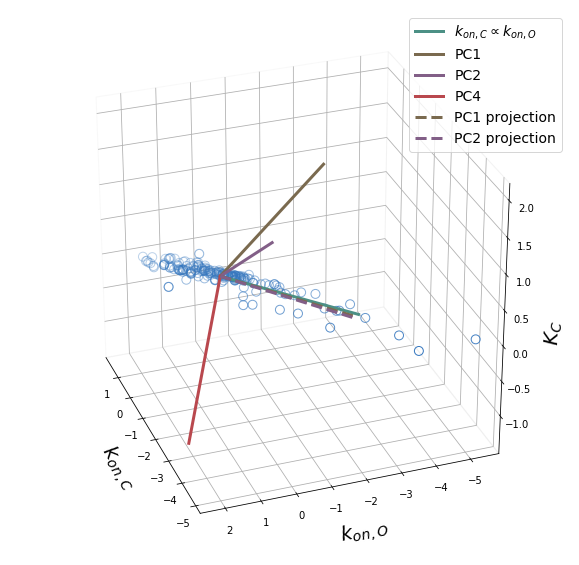

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
    
ax.set_xlabel('$k_{on,C}$', fontsize=20, labelpad=12)
ax.set_ylabel('$k_{on,O}$', fontsize=20, labelpad=12)
ax.set_zlabel('$K_C$', fontsize=20, labelpad=12)


PC1vec = np.vstack([np.zeros(4), 4*PC1])
PC2vec = np.vstack([np.zeros(4), 4*PC2])
PC3vec = np.vstack([np.zeros(4), 4*PC3])
PC4vec = np.vstack([np.zeros(4), 4*PC4])
PC1_plane_vec = np.vstack([np.zeros(4), 4*PC1_plane])
PC2_plane_vec = np.vstack([np.zeros(4), 4*PC2_plane])
corr_axis = np.vstack([np.zeros(4), -4*unit_corr])

ax.scatter(F1data[:, 0], F1data[:, 1], np.zeros(F1data.shape[0]),
           facecolors='none', edgecolors=named_colors[0], s=80)
#ax.scatter(F1data[:, 0], F1data[:, 1], F1data[:, 2],
#           facecolors='none', edgecolors=named_colors[1], s=80)

ax.plot(corr_axis[:, 0], corr_axis[:, 1], corr_axis[:, 2], c=named_colors[4], lw=3,
        label='$k_{on,C} \propto k_{on,O}$')

ax.plot(PC1vec[:, 0], PC1vec[:, 1], PC1vec[:, 2], c=named_colors[2], label='PC1', lw=3)
ax.plot(PC2vec[:, 0], PC2vec[:, 1], PC2vec[:, 2], c=named_colors[3], label='PC2', lw=3)
#ax.plot(PC3vec[:, 0], PC3vec[:, 1], PC3vec[:, 2], c=named_colors[-1], label='PC3', lw=3)
ax.plot(PC4vec[:, 0], PC4vec[:, 1], PC4vec[:, 2], c=named_colors[-1], label='PC4', lw=3)

ax.plot(PC1_plane_vec[:, 0], PC1_plane_vec[:, 1], PC1_plane_vec[:, 2],
        c=named_colors[2], label='PC1 projection', lw=3, ls='--')
ax.plot(PC2_plane_vec[:, 0], PC2_plane_vec[:, 1], PC2_plane_vec[:, 2],
        c=named_colors[3], label='PC2 projection', lw=3, ls='--')

# Set the viewing angle
ax.view_init(30, 160)

#def _logscale(x, pos):
#    return '$10^{%d}$' % x
#formatter = FuncFormatter(_logscale)
#ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
#ax.zaxis.set_major_formatter(formatter)
#ax.xaxis.set_tick_params(labelsize=12, pad=2)
#ax.yaxis.set_tick_params(labelsize=12, pad=2)
#ax.zaxis.set_tick_params(labelsize=12, pad=6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.legend(fontsize=14)
#ax.tick_params(pad=30)

#ax.set_ylim(-5, 5)
#ax.set_xlim(-5, 5)
#ax.set_zlim(-8, 8)
plt.show()

No handles with labels found to put in legend.


1.3877787807814457e-16
-0.08831909291030493
[-0.55216679 -0.51692707  0.42556369]
[-0.29110493 -0.26152669 -0.9029149 ]


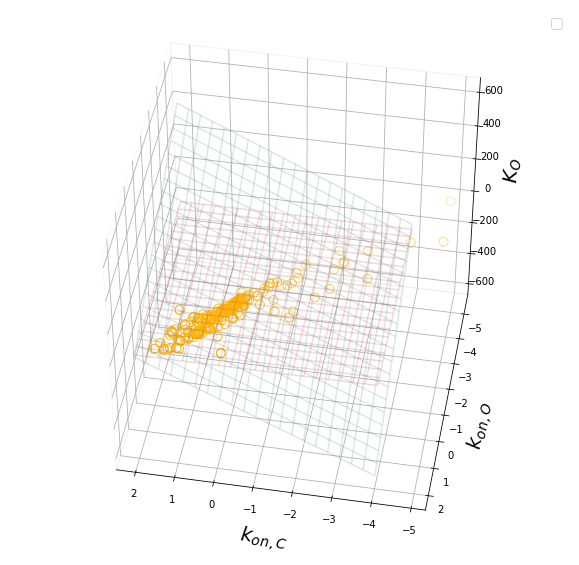

In [56]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
    
ax.set_xlabel('$k_{on,C}$', fontsize=20, labelpad=12)
ax.set_ylabel('$k_{on,O}$', fontsize=20, labelpad=12)
ax.set_zlabel('$K_O$', fontsize=20, labelpad=12)

#ax.scatter(F1data[:, 0], F1data[:, 1], np.zeros(F1data.shape[0]),
#           facecolors='none', edgecolors=named_colors[0], s=80)
ax.scatter(F1data[:, 0], F1data[:, 1], F1data[:, 3],
           facecolors='none', edgecolors=named_colors[1], s=80)

corr_axis = np.vstack([np.zeros(4), -4*unit_corr])
#ax.plot(corr_axis[:, 0], corr_axis[:, 1], corr_axis[:, 2], c=named_colors[4], lw=3,
#        label='$k_{on,C} \propto k_{on,O}$')

# Calculate plane spanned by 3D projection of PC1-2 onto [konC, konO, KO]
pc1_sub = PC1[[0, 1, 3]]
pc2_sub = PC2[[0, 1, 3]]
pc1_subnorm = pc1_sub / np.linalg.norm(pc1_sub)
pc2_subnorm = pc2_sub / np.linalg.norm(pc2_sub)

print(PC1.dot(PC2))
print(pc1_sub.dot(pc2_sub))
print(pc1_sub)
print(pc2_sub)
normal = np.cross(pc1_subnorm, pc2_subnorm)
d = -pc1_subnorm.dot(normal)

# create x,y
domain = np.arange(-4, 2, 0.01)
xx, yy = np.meshgrid(domain, domain)
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

ax.plot_wireframe(xx, yy, z, alpha=0.2, rstride=30, cstride=30, color=named_colors[4])
ax.plot_wireframe(xx, yy, np.zeros(xx.shape), alpha=0.2, rstride=30, cstride=30, color=named_colors[5])

PC1vec = np.vstack([np.zeros(4), 4*PC1])
PC2vec = np.vstack([np.zeros(4), 4*PC2])
#ax.plot(PC1vec[:, 0], PC1vec[:, 1], PC1vec[:, 3], c=named_colors[2], label='PC1', lw=3)
#ax.plot(PC2vec[:, 0], PC2vec[:, 1], PC2vec[:, 3], c=named_colors[3], label='PC2', lw=3)

# Set the viewing angle
ax.view_init(45, 100)

#def _logscale(x, pos):
#    return '$10^{%d}$' % x
#formatter = FuncFormatter(_logscale)
#ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
#ax.zaxis.set_major_formatter(formatter)
#ax.xaxis.set_tick_params(labelsize=12, pad=2)
#ax.yaxis.set_tick_params(labelsize=12, pad=2)
#ax.zaxis.set_tick_params(labelsize=12, pad=6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.legend(fontsize=14)
#ax.tick_params(pad=30)

#ax.set_ylim(-5, 5)
#ax.set_xlim(-5, 5)
#ax.set_zlim(-100, 100)
plt.show()



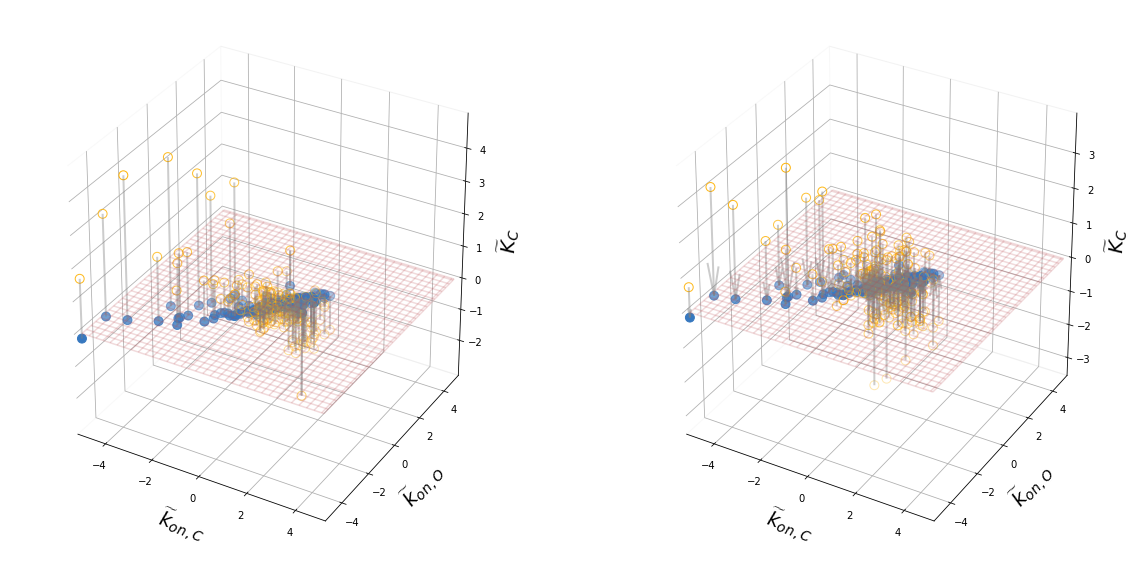

In [90]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('$\widetilde{k}_{on,C}$', fontsize=20, labelpad=12)
ax.set_ylabel('$\widetilde{k}_{on,O}$', fontsize=20, labelpad=12)
ax.set_zlabel('$\widetilde{K}_C$', fontsize=20, labelpad=12)

ax.scatter(F1data[:, 0], F1data[:, 1], np.zeros(F1data.shape[0]),
           facecolors=named_colors[0], edgecolors=named_colors[0], s=80)
ax.scatter(F1data[:, 0], F1data[:, 1], F1data[:, 2],
           facecolors='none', edgecolors=named_colors[1], s=80)


zs = np.zeros(F1data.shape[0])
ax.quiver(F1data[:, 0], F1data[:, 1], F1data[:, 2],
          zs, zs, -F1data[:, 2], alpha=0.4, color='grey', lw=2,
          normalize=False, arrow_length_ratio=0)

domain = np.arange(-5, 5, 0.01)
xx, yy = np.meshgrid(domain, domain)
ax.plot_wireframe(xx, yy, np.zeros(xx.shape), alpha=0.2, rstride=30, cstride=30, color=named_colors[5])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 5)

ax = fig.add_subplot(122, projection='3d')

ax.set_xlabel('$\widetilde{k}_{on,C}$', fontsize=20, labelpad=12)
ax.set_ylabel('$\widetilde{k}_{on,O}$', fontsize=20, labelpad=12)
ax.set_zlabel('$\widetilde{K}_C$', fontsize=20, labelpad=12)

ax.scatter(F1data[:, 0], F1data[:, 1], np.zeros(F1data.shape[0]),
           facecolors=named_colors[0], edgecolors=named_colors[0], s=80)
ax.scatter(F1data[:, 0], F1data[:, 1], F1data[:, 3],
           facecolors='none', edgecolors=named_colors[1], s=80)


zs = np.zeros(F1data.shape[0])
ax.quiver(F1data[:, 0], F1data[:, 1], F1data[:, 3],
          zs, zs, -F1data[:, 3], alpha=0.4, color='grey', lw=2,
          normalize=False)

domain = np.arange(-5, 5, 0.01)
xx, yy = np.meshgrid(domain, domain)
ax.plot_wireframe(xx, yy, np.zeros(xx.shape), alpha=0.2, rstride=30, cstride=30, color=named_colors[5])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_ylim(-5, 5)
ax.set_xlim(-5, 5)
#ax.set_zlim(-100, 100)
plt.show()



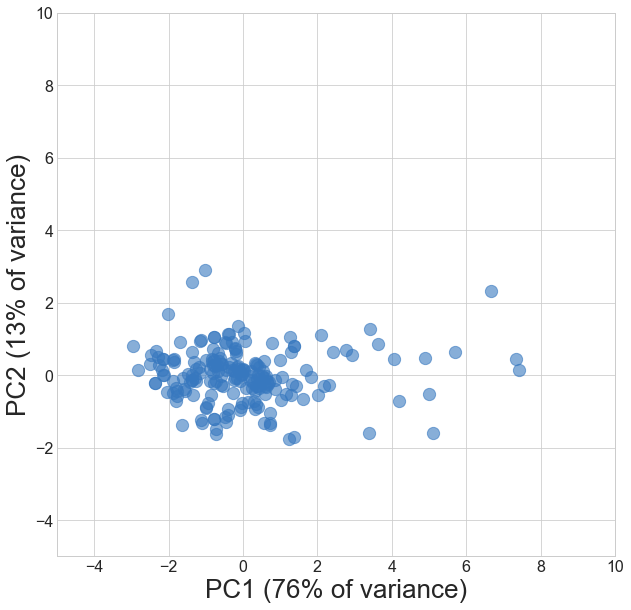

In [94]:
# Plot PCA of normalized data for all RuBisCOs
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

pcts = 100*fitted_F1.explained_variance_ratio_
transformed = fitted_F1.transform(F1data)

plt.scatter(transformed[:, 0], transformed[:, 1], s=150, c=named_colors[0], alpha=0.6)

plt.xlabel('PC1 (%d%% of variance)' % pcts[0], fontsize=26)
plt.ylabel('PC2 (%d%% of variance)' % pcts[1], fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.show()

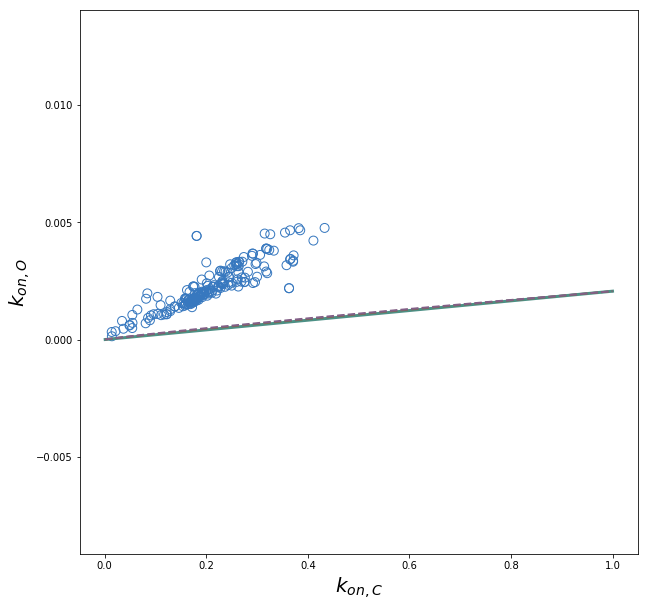

In [11]:
fig = plt.figure(figsize=(10,10))
    
#plt.xscale('log')
#plt.yscale('log')
F1_kin = kin_df[kin_df.isoform == '1']
plt.scatter(F1_kin.kon_C, F1_kin.kon_O,
            facecolors='none', edgecolors=named_colors[0], s=80)

xs = np.arange(1e-3, 1, 1e-4)
log_xvals = np.log(kin_df.kon_C)
log_yvals = np.log(kin_df.kon_O)
means_logscale = np.array([np.mean(log_xvals), np.mean(log_yvals)])
mean_y = np.exp(means_logscale[1])

PC1_slope = PC1_plane[1] / PC1_plane[0]
PC2_slope = PC2_plane[1] / PC2_plane[0]
PC1_ys = mean_y*np.power(xs, PC1_slope)
PC2_ys = mean_y*np.power(xs, PC2_slope)
corr_ys = mean_y*xs

plt.plot(xs, corr_ys, c=named_colors[4], lw=3,
         label='$k_{on,C} \propto k_{on,O}^1$')
plt.plot(xs, PC1_ys, 
         c=named_colors[2], label='PC1 projection', lw=2, ls='--')
plt.plot(xs, PC2_ys, 
         c=named_colors[3], label='PC2 projection', lw=2, ls='--')

ax.legend(fontsize=14)
plt.xlabel('$k_{on,C}$', fontsize=20)
plt.ylabel('$k_{on,O}$', fontsize=20)
plt.show()